In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch 
import os
torch.cuda.is_available()


True

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# data = pd.read_csv('walk_1.csv')
N = 100 # 샘플수
L = 1000 # 샘플의 길이
T = 20 # 매개변수 t

#샘플 만들기
x = np.empty((N, L), np.float32) #N은샘플 L은 샘플의 길이 데이터 유형 float 32



In [4]:
print(x)

[[-9.371124e+30  3.068283e-41  0.000000e+00 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 ...
 [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
   0.000000e+00  0.000000e+00]]


In [5]:
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
# print(x)
y = np.sin(x/1.0/T).astype(np.float32)

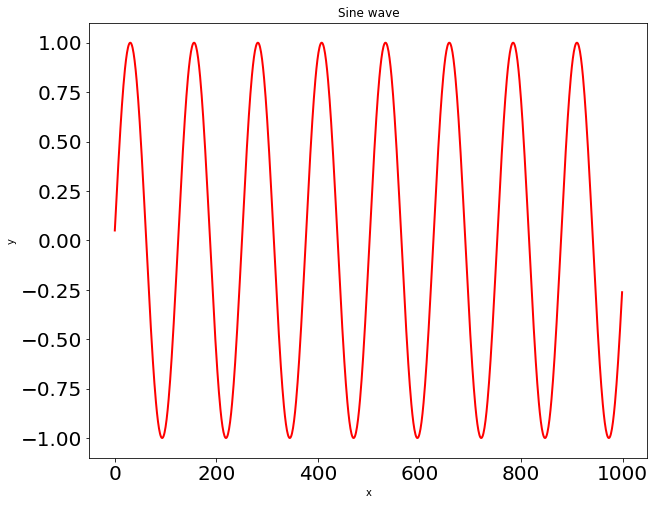

In [6]:
plt.figure(figsize=(10,8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]), y[0,:],'r',linewidth=2.0)
# plt.show()

In [11]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1,self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden,self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)
        
    def forward(self, x, future=0):
        # N, 100
        outputs = []
        n_samples = x.size(0)
        
        h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        
        for input_t in x.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        outputs = torch.cat(outputs, dim=1)
        return output


In [15]:
    
if __name__ == "__main__":
    # y = 100, 1000
    train_input = torch.from_numpy(y[3:, :-1]) # 97, 999 97개 샘플 999개의 값
    train_target = torch.from_numpy(y[3:, 1:]) # 97, 999
    test_input = torch.from_numpy(y[:3, :-1]) # 3, 999
    test_target = torch.from_numpy(y[:3, 1:]) # 3, 999
    
    model = LSTMPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.LBFGS(model.parameters(), lr = 0.8)
    
    n_steps = 10
    for i in range(n_steps):
        print("Step", i)
        
        def closure():
            optimizer.zero_grad()
            out = model(train_input)
            loss = criterion(out, train_target)
            print("loss", loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
        
        with torch.no_grad():
            future=1000
            pred = model(test_input, future=future).to(device)
            loss = criterion(pred[0:, :-future], test_target)
            print("test loss", loss.item())
            y = pred.detach().numpy()
            
        plt.figure(figsize=(12,6))
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        def draw(y_i, color):
            plt.plot(np.arange(n), y_i[:n],color, linewidth=2.0)
            plt.plot(np.arange(n, n+future), y_i[n:],color + ":", linewidth=2.0)
        draw[y[0],'r']
        draw[y[1],'b']    
        draw[y[2],'g']
        plt.savefig("predict%d.pdf"%i)
        plt.close()
        
        
    

Step 0


/home/master/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([97, 999])) that is different to the input size (torch.Size([97, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss 0.5261721014976501
loss 0.5123144388198853
loss 0.5010051727294922
loss 0.5005358457565308
loss 0.5005162358283997
loss 0.5005141496658325
loss 0.5005117654800415
loss 0.5005061626434326
loss 0.5004953742027283
loss 0.5004786849021912
loss 0.5004605650901794
loss 0.5004526376724243
loss 0.500451385974884
loss 0.5004512667655945
loss 0.5004512667655945


/home/master/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([3, 999])) that is different to the input size (torch.Size([3, 0])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (0) must match the size of tensor b (999) at non-singleton dimension 1